<p>Generative adversarial networks (GANs) are very common in the machine learning and computer vision communities.
GANs are part of algorithms belonging to unsupervised learning. GANs find applications in many fields including Generating realistic artwork samples, statistical inference, and data augmentation.
A GAN is usually composed of one Generator which aims at generating new data similar to an expected one, and a discriminator which goal is to predict whether the fed data is real or fake.
The purpose of this TP is to generate new data samples to augment our dataset “NewData”.
    </p>
    <ul>
<li>
1) Define a Discriminator network which distinguish between real and fake data.
    </li>
<li>2) Define a Generator network which take a noise vector and generates a new sample of data. </li>
<li>3) Define the optimization tools. </li>
<li>4) Train both the discriminator and the generator. </li>
<li>    5) Report and interpret the retrieved results. (qualitative and quantitative results) </li></ul>

# 0. Import our dataset "NewData"

In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
from torchvision.datasets import ImageFolder
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
%%capture
!pip install wandb -q

In [ ]:
%%capture
!unzip Newdata.zip && mv Newdata/Test/Shape1/ Newdata/Test/Cow/ && mv Newdata/Test/Shape2/ Newdata/Test/Horse/

In [ ]:
BATCH_SIZE = 16

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = ImageFolder('/content/Newdata/Train',transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
testset = ImageFolder('/content/Newdata/Test',transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)
CLASS_NAMES = ('Cow', 'Horse')

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(15):
      ax = plt.subplot(5,5,n+1)
      img = image_batch[n] / 2 + 0.5     # unnormalize
      img = img.numpy()
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.title(CLASS_NAMES[label_batch[n]])
      plt.axis('off')

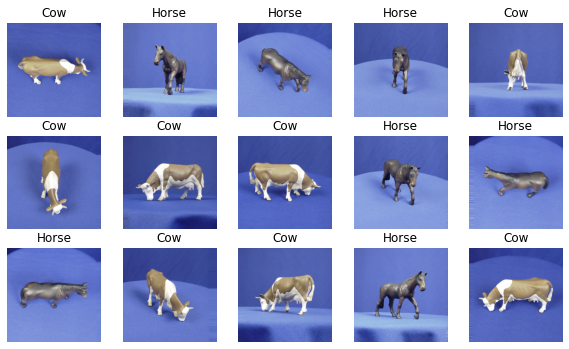

In [ ]:
sample_images, sample_labels = next(iter(trainloader))
show_batch(sample_images, sample_labels)

(3, 256, 256)


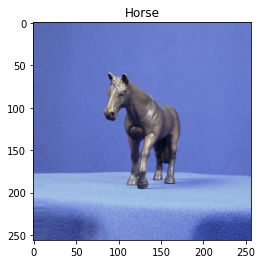

In [ ]:
img = sample_images[1] / 2 + 0.5     # unnormalize
img = img.numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.title(CLASS_NAMES[sample_labels[1]])
print(img.shape)

In [ ]:
for x, y in trainloader: 
  print(x.shape, y.shape)
  break

torch.Size([16, 3, 256, 256]) torch.Size([16])


In [ ]:
h,w = 256, 256

# 1. Define a Discriminator network which distinguish between real and fake data

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super(Discriminator, self).__init__()
        nic= params["nic"]
        ndf = params["ndf"]
        self.conv1 = nn.Conv2d(nic, ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)            
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x), 0.2, True)
        x = F.relu(self.bn2(self.conv2(x)), 0.2, inplace = True)
        x = F.relu(self.bn3(self.conv3(x)), 0.2, inplace = True)
        x = F.relu(self.bn4(self.conv4(x)), 0.2, inplace = True)        
        
        out = torch.sigmoid(self.conv5(x))
        return out.view(-1)

In [ ]:
params_dis = {
    "nic": 3,
    "ndf": 64}
model_dis = Discriminator(params_dis)
device = torch.device("cuda:3")
print(model_dis)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [ ]:
with torch.no_grad():
    y= model_dis(torch.zeros(1,3,h,w))
print(y.shape)

torch.Size([169])


In [ ]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 2. Define a Generator network which take a noise vector and generates a new sample of data.

In [ ]:
from torch import nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        nz = params["nz"]
        ngf = params["ngf"]
        noc = params["noc"]
        self.dconv1 = nn.ConvTranspose2d( nz, ngf * 8, kernel_size=4,
                                         stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)
        self.dconv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.dconv3 = nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.dconv4 = nn.ConvTranspose2d( ngf * 2, ngf, kernel_size=4, 
                                         stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.dconv5 = nn.ConvTranspose2d( ngf, noc, kernel_size=4, 
                                         stride=2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.dconv1(x)))
        x = F.relu(self.bn2(self.dconv2(x)))            
        x = F.relu(self.bn3(self.dconv3(x)))        
        x = F.relu(self.bn4(self.dconv4(x)))    
        out = torch.tanh(self.dconv5(x))
        return out

In [ ]:
params_gen = {
        "nz": 100,
        "ngf": 64,
        "noc": 3,
        }
model_gen = Generator(params_gen)
device = torch.device("cuda:3")
print(model_gen)

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [ ]:
with torch.no_grad():
    y= model_gen(torch.zeros(1,100,1,1))
print(y.shape)

torch.Size([1, 3, 64, 64])


In [ ]:
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

# 3. Define the optimization tools 

In [ ]:
loss_func = nn.BCEWithLogitsLoss()

In [ ]:
from torch import optim

lr = 2e-4 
beta1 = 0.5
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, 0.999))

# 4. Train both the discriminator and the generator

In [145]:
real_label = 1
fake_label = 0
nz = params_gen["nz"]
num_epochs = 3000


loss_history={"gen": [],
              "dis": []}

batch_count = 0
for epoch in range(num_epochs):
    for xb, yb in trainloader:
        print(epoch)
        ba_si = xb.size(0)
        model_dis.zero_grad()
        #xb = xb.to(device)
        yb = torch.full((ba_si,), real_label)
        out_dis = model_dis(xb)
        print(out_dis.shape)
        loss_r = loss_func(out_dis, yb)
        loss_r.backward()

        noise = torch.randn(ba_si, nz, 1, 1)
        out_gen = model_gen(noise)
        out_dis = model_dis(out_gen.detach())
        yb.fill_(fake_label)    
        loss_f = loss_func(out_dis, yb)
        loss_f.backward()
        loss_dis = loss_r + loss_f  
        opt_dis.step()   

        model_gen.zero_grad()
        yb.fill_(real_label)  
        out_dis = model_dis(out_gen)
        loss_gen = loss_func(out_dis, yb)
        loss_gen.backward()
        opt_gen.step()

        loss_history["gen"].append(loss_gen.item())
        loss_history["dis"].append(loss_dis.item())
        batch_count += 1
        if batch_count % 100 == 0:
            print(epoch, loss_gen.item(),loss_dis.item())

0
torch.Size([2704])


ValueError: ignored

# 5. Report and interpret the retrieved results (Qualitative and quantitative results) : 